# Power Systems

**This tutorial was originally contributed by Yury Dvorkin and Miles Lubin.**

This tutorial demonstrates how to formulate basic power systems engineering
models in JuMP.

We will consider basic "economic dispatch" and "unit commitment" models
without taking into account transmission constraints.

For this tutorial, we use the following packages:

In [1]:
using JuMP
import DataFrames
import HiGHS
import Plots
import StatsPlots

## Economic dispatch

Economic dispatch (ED) is an optimization problem that minimizes the cost of
supplying energy demand subject to operational constraints on power system
assets. In its simplest modification, ED is an LP problem solved for an
aggregated load and wind forecast and for a single infinitesimal moment.

Mathematically, the ED problem can be written as follows:

$$
\min \sum_{i \in I} c^g_{i} \cdot g_{i} + c^w \cdot w,
$$

where $c_{i}$ and $g_{i}$ are the incremental cost 
($\$$/MWh) and power output (MW) of the $i^{th}$ generator, respectively, and $c^w$ and $w$ are the
incremental cost ($\$$/MWh) and wind power injection (MW), respectively.

Subject to the constraints:

* Minimum ($g^{\min}$) and maximum ($g^{\max}$) limits on power outputs of
  generators:
  $g^{\min}_{i} \leq g_{i} \leq g^{\max}_{i}.$
* Constraint on the wind power injection:
  $0 \leq w \leq w^f,$
  where $w$ and $w^f$ are the wind power injection and wind power forecast,
  respectively.
* Power balance constraint:
  $\sum_{i \in I} g_{i} + w = d^f,$
  where $d^f$ is the demand forecast.

Further reading on ED models can be found in A. J. Wood, B. F. Wollenberg, and
G. B. Sheblé, "Power Generation, Operation and Control," Wiley, 2013.

Define some input data about the test system.

We define some thermal generators:

In [2]:
function ThermalGenerator(
    min::Float64,
    max::Float64,
    fixed_cost::Float64,
    variable_cost::Float64,
)
    return (
        min = min,
        max = max,
        fixed_cost = fixed_cost,
        variable_cost = variable_cost,
    )
end

generators = [
    ThermalGenerator(0.0, 1000.0, 1000.0, 50.0),
    ThermalGenerator(300.0, 1000.0, 0.0, 100.0),
]

2-element Vector{@NamedTuple{min::Float64, max::Float64, fixed_cost::Float64, variable_cost::Float64}}:
 (min = 0.0, max = 1000.0, fixed_cost = 1000.0, variable_cost = 50.0)
 (min = 300.0, max = 1000.0, fixed_cost = 0.0, variable_cost = 100.0)

A wind generator

In [3]:

WindGenerator(variable_cost::Float64) = (variable_cost = variable_cost,)

wind_generator = WindGenerator(50.0)


(variable_cost = 50.0,)

And a scenario

In [4]:
function Scenario(demand::Float64, wind::Float64)
    return (demand = demand, wind = wind)
end

scenario = Scenario(1500.0, 200.0)

(demand = 1500.0, wind = 200.0)

Create a function `solve_economic_dispatch`, which solves the economic dispatch problem for a given set of input parameters.

In [5]:

function solve_economic_dispatch(generators::Vector, wind, scenario)
    ## Define the economic dispatch (ED) model
    model = Model(HiGHS.Optimizer)
    set_silent(model)
    ## Define decision variables
    ## power output of generators
    N = length(generators)
    @variable(model, generators[i].min <= g[i = 1:N] <= generators[i].max)
    ## wind power injection
    @variable(model, 0 <= w <= scenario.wind)
    ## Define the objective function
    @objective(
        model,
        Min,
        sum(generators[i].variable_cost * g[i] for i in 1:N) +
        wind.variable_cost * w,
    )
    ## Define the power balance constraint
    @constraint(model, sum(g[i] for i in 1:N) + w == scenario.demand)
    ## Solve statement
    optimize!(model)
    # assert_is_solved_and_feasible(model)
    # return the optimal value of the objective function and its minimizers
    return (
        g = value.(g),
        w = value(w),
        wind_spill = scenario.wind - value(w),
        total_cost = objective_value(model),
    )
end

solve_economic_dispatch (generic function with 1 method)

Solve the economic dispatch problem

In [6]:
solution = solve_economic_dispatch(generators, wind_generator, scenario);

println("Dispatch of Generators: ", solution.g, " MW")
println("Dispatch of Wind: ", solution.w, " MW")
println("Wind spillage: ", solution.wind_spill, " MW")
println("Total cost: \$", solution.total_cost)

Dispatch of Generators: [1000.0, 300.0] MW
Dispatch of Wind: 200.0 MW
Wind spillage: 0.0 MW
Total cost: $90000.0


## Economic dispatch with adjustable incremental costs

In the following exercise we adjust the incremental cost of generator G1 and
observe its impact on the total cost.

In [7]:
function scale_generator_cost(g, scale)
    return ThermalGenerator(g.min, g.max, g.fixed_cost, scale * g.variable_cost)
end

start = time()
c_g_scale_df = DataFrames.DataFrame(;
    ## Scale factor
    scale = Float64[],
    ## Dispatch of Generator 1 [MW]
    dispatch_G1 = Float64[],
    ## Dispatch of Generator 2 [MW]
    dispatch_G2 = Float64[],
    ## Dispatch of Wind [MW]
    dispatch_wind = Float64[],
    ## Spillage of Wind [MW]
    spillage_wind = Float64[],
    ## Total cost [$]
    total_cost = Float64[],
)
for c_g1_scale in 0.5:0.1:3.0
    ## Update the incremental cost of the first generator at every iteration.
    new_generators = scale_generator_cost.(generators, [c_g1_scale, 1.0])
    ## Solve the economic-dispatch problem with the updated incremental cost
    sol = solve_economic_dispatch(new_generators, wind_generator, scenario)
    push!(
        c_g_scale_df,
        (c_g1_scale, sol.g[1], sol.g[2], sol.w, sol.wind_spill, sol.total_cost),
    )
end
print(string("elapsed time: ", time() - start, " seconds"))

elapsed time: 0.15481805801391602 seconds

In [8]:
c_g_scale_df

Row,scale,dispatch_G1,dispatch_G2,dispatch_wind,spillage_wind,total_cost
,Float64,Float64,Float64,Float64,Float64,Float64
1,0.5,1000.0,300.0,200.0,0.0,65000.0
2,0.6,1000.0,300.0,200.0,0.0,70000.0
3,0.7,1000.0,300.0,200.0,0.0,75000.0
4,0.8,1000.0,300.0,200.0,0.0,80000.0
5,0.9,1000.0,300.0,200.0,0.0,85000.0
6,1.0,1000.0,300.0,200.0,0.0,90000.0
7,1.1,1000.0,300.0,200.0,0.0,95000.0
8,1.2,1000.0,300.0,200.0,0.0,100000.0
9,1.3,1000.0,300.0,200.0,0.0,105000.0


## Modifying the JuMP model in-place

Note that in the previous exercise we entirely rebuilt the optimization model
at every iteration of the internal loop, which incurs an additional
computational burden. This burden can be alleviated if instead of re-building
the entire model, we modify the constraints or objective
function, as it shown in the example below.

Compare the computing time in case of the above and below models.

In [9]:
function solve_economic_dispatch_inplace(
    generators::Vector,
    wind,
    scenario,
    scale::AbstractVector{Float64},
)
    obj_out = Float64[]
    w_out = Float64[]
    g1_out = Float64[]
    g2_out = Float64[]
    ## This function only works for two generators
    @assert length(generators) == 2
    model = Model(HiGHS.Optimizer)
    set_silent(model)
    N = length(generators)
    @variable(model, generators[i].min <= g[i = 1:N] <= generators[i].max)
    @variable(model, 0 <= w <= scenario.wind)
    @objective(
        model,
        Min,
        sum(generators[i].variable_cost * g[i] for i in 1:N) +
        wind.variable_cost * w,
    )
    @constraint(model, sum(g[i] for i in 1:N) + w == scenario.demand)
    for c_g1_scale in scale
        @objective(
            model,
            Min,
            c_g1_scale * generators[1].variable_cost * g[1] +
            generators[2].variable_cost * g[2] +
            wind.variable_cost * w,
        )
        optimize!(model)
        # assert_is_solved_and_feasible(model)
        push!(obj_out, objective_value(model))
        push!(w_out, value(w))
        push!(g1_out, value(g[1]))
        push!(g2_out, value(g[2]))
    end
    df = DataFrames.DataFrame(;
        scale = scale,
        dispatch_G1 = g1_out,
        dispatch_G2 = g2_out,
        dispatch_wind = w_out,
        spillage_wind = scenario.wind .- w_out,
        total_cost = obj_out,
    )
    return df
end

start = time()
inplace_df = solve_economic_dispatch_inplace(
    generators,
    wind_generator,
    scenario,
    0.5:0.1:3.0,
)
print(string("elapsed time: ", time() - start, " seconds"))


elapsed time: 0.08289599418640137 seconds

For small models, adjusting specific constraints or the objective function is
sometimes faster and sometimes slower than re-building the entire model.
However, as the problem size increases, updating the model in-place is usually
faster.

In [10]:
inplace_df

Row,scale,dispatch_G1,dispatch_G2,dispatch_wind,spillage_wind,total_cost
,Float64,Float64,Float64,Float64,Float64,Float64
1,0.5,1000.0,300.0,200.0,0.0,65000.0
2,0.6,1000.0,300.0,200.0,0.0,70000.0
3,0.7,1000.0,300.0,200.0,0.0,75000.0
4,0.8,1000.0,300.0,200.0,0.0,80000.0
5,0.9,1000.0,300.0,200.0,0.0,85000.0
6,1.0,1000.0,300.0,200.0,0.0,90000.0
7,1.1,1000.0,300.0,200.0,0.0,95000.0
8,1.2,1000.0,300.0,200.0,0.0,100000.0
9,1.3,1000.0,300.0,200.0,0.0,105000.0


## Inefficient usage of wind generators

The economic dispatch problem does not perform commitment decisions and, thus,
assumes that all generators must be dispatched at least at their minimum power
output limit. This approach is not cost efficient and may lead to absurd
decisions. For example, if $d = \sum_{i \in I} g^{\min}_{i}$, the wind power
injection must be zero, that is, all available wind generation is spilled, to meet
the minimum power output constraints on generators.

In the following example, we adjust the total demand and observed how it
affects wind spillage.

In [11]:
demand_scale_df = DataFrames.DataFrame(;
    demand = Float64[],
    dispatch_G1 = Float64[],
    dispatch_G2 = Float64[],
    dispatch_wind = Float64[],
    spillage_wind = Float64[],
    total_cost = Float64[],
)

function scale_demand(scenario, scale)
    return Scenario(scale * scenario.demand, scenario.wind)
end

for demand_scale in 0.2:0.1:1.4
    new_scenario = scale_demand(scenario, demand_scale)
    sol = solve_economic_dispatch(generators, wind_generator, new_scenario)
    push!(
        demand_scale_df,
        (
            new_scenario.demand,
            sol.g[1],
            sol.g[2],
            sol.w,
            sol.wind_spill,
            sol.total_cost,
        ),
    )
end


In [12]:
demand_scale_df

Row,demand,dispatch_G1,dispatch_G2,dispatch_wind,spillage_wind,total_cost
,Float64,Float64,Float64,Float64,Float64,Float64
1,300.0,0.0,300.0,0.0,200.0,30000.0
2,450.0,150.0,300.0,0.0,200.0,37500.0
3,600.0,300.0,300.0,0.0,200.0,45000.0
4,750.0,450.0,300.0,0.0,200.0,52500.0
5,900.0,600.0,300.0,0.0,200.0,60000.0
6,1050.0,750.0,300.0,0.0,200.0,67500.0
7,1200.0,900.0,300.0,0.0,200.0,75000.0
8,1350.0,850.0,300.0,200.0,0.0,82500.0
9,1500.0,1000.0,300.0,200.0,0.0,90000.0


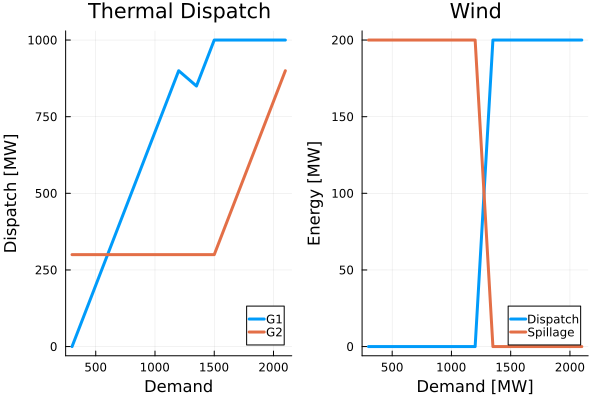

In [13]:
dispatch_plot = StatsPlots.@df(
    demand_scale_df,
    Plots.plot(
        :demand,
        [:dispatch_G1, :dispatch_G2],
        labels = ["G1" "G2"],
        title = "Thermal Dispatch",
        legend = :bottomright,
        linewidth = 3,
        xlabel = "Demand",
        ylabel = "Dispatch [MW]",
    ),
)

wind_plot = StatsPlots.@df(
    demand_scale_df,
    Plots.plot(
        :demand,
        [:dispatch_wind, :spillage_wind],
        labels = ["Dispatch" "Spillage"],
        title = "Wind",
        legend = :bottomright,
        linewidth = 3,
        xlabel = "Demand [MW]",
        ylabel = "Energy [MW]",
    ),
)

Plots.plot(dispatch_plot, wind_plot)

This particular drawback can be overcome by introducing binary decisions on
the "on/off" status of generators. This model is called unit commitment and
considered later in these notes.

For further reading on the interplay between wind generation and the minimum
power output constraints of generators, we refer interested readers to R.
Baldick, "Wind and energy markets: a case study of Texas," IEEE Systems
Journal, vol. 6, pp. 27-34, 2012.

## Unit commitment

The Unit Commitment (UC) model can be obtained from ED model by introducing
binary variable associated with each generator. This binary variable can
attain two values: if it is "1," the generator is synchronized and, thus, can
be dispatched, otherwise, that is, if the binary variable is "0," that generator
is not synchronized and its power output is set to 0.

To obtain the mathematical formulation of the UC model, we will modify the
constraints of the ED model as follows:

$$
g^{\min}_{i} \cdot u_{t,i} \leq g_{i} \leq g^{\max}_{i} \cdot u_{t,i},
$$
where $u_{i} \in \{0,1\}.$ In this constraint, if $u_{i} = 0$, then
$g_{i}  = 0$. On the other hand, if $u_{i} = 1$, then
$g^{min}_{i} \leq g_{i} \leq g^{max}_{i}$.

For further reading on the UC problem we refer interested readers to G.
Morales-Espana, J. M. Latorre, and A. Ramos, "Tight and Compact MILP
Formulation for the Thermal Unit Commitment Problem," IEEE Transactions on
Power Systems, vol. 28, pp. 4897-4908, 2013.

In the following example we convert the ED model explained above to the UC
model.

In [14]:
function solve_unit_commitment(generators::Vector, wind, scenario)
    model = Model(HiGHS.Optimizer)
    set_silent(model)
    N = length(generators)
    @variable(model, 0 <= g[i = 1:N] <= generators[i].max)
    @variable(model, 0 <= w <= scenario.wind)
    @constraint(model, sum(g[i] for i in 1:N) + w == scenario.demand)
    ## !!! New: add binary on-off variables for each generator
    @variable(model, u[i = 1:N], Bin)
    @constraint(model, [i = 1:N], g[i] <= generators[i].max * u[i])
    @constraint(model, [i = 1:N], g[i] >= generators[i].min * u[i])
    @objective(
        model,
        Min,
        sum(generators[i].variable_cost * g[i] for i in 1:N) +
        wind.variable_cost * w +
        ## !!! new
        sum(generators[i].fixed_cost * u[i] for i in 1:N)
    )
    optimize!(model)
    status = termination_status(model)
    if status != OPTIMAL
        return (status = status,)
    end
    @assert primal_status(model) == FEASIBLE_POINT
    return (
        status = status,
        g = value.(g),
        w = value(w),
        wind_spill = scenario.wind - value(w),
        u = value.(u),
        total_cost = objective_value(model),
    )
end

solve_unit_commitment (generic function with 1 method)

Solve the unit commitment problem

In [15]:
solution = solve_unit_commitment(generators, wind_generator, scenario)

println("Dispatch of Generators: ", solution.g, " MW")
println("Commitments of Generators: ", solution.u)
println("Dispatch of Wind: ", solution.w, " MW")
println("Wind spillage: ", solution.wind_spill, " MW")
println("Total cost: \$", solution.total_cost)

Dispatch of Generators: [1000.0, 300.0] MW
Commitments of Generators: [1.0, 1.0]
Dispatch of Wind: 200.0 MW
Wind spillage: 0.0 MW
Total cost: $91000.0


## Unit commitment as a function of demand

After implementing the unit commitment model, we can now assess the interplay
between the minimum power output constraints on generators and wind
generation.

In [16]:
uc_df = DataFrames.DataFrame(;
    demand = Float64[],
    commitment_G1 = Float64[],
    commitment_G2 = Float64[],
    dispatch_G1 = Float64[],
    dispatch_G2 = Float64[],
    dispatch_wind = Float64[],
    spillage_wind = Float64[],
    total_cost = Float64[],
)

for demand_scale in 0.2:0.1:1.4
    new_scenario = scale_demand(scenario, demand_scale)
    sol = solve_unit_commitment(generators, wind_generator, new_scenario)
    if sol.status == OPTIMAL
        push!(
            uc_df,
            (
                new_scenario.demand,
                sol.u[1],
                sol.u[2],
                sol.g[1],
                sol.g[2],
                sol.w,
                sol.wind_spill,
                sol.total_cost,
            ),
        )
    end
    println("Status: $(sol.status) for demand_scale = $(demand_scale)")
end

Status: OPTIMAL for demand_scale = 0.2
Status: OPTIMAL for demand_scale = 0.3
Status: OPTIMAL for demand_scale = 0.4
Status: OPTIMAL for demand_scale = 0.5
Status: OPTIMAL for demand_scale = 0.6
Status: OPTIMAL for demand_scale = 0.7
Status: OPTIMAL for demand_scale = 0.8
Status: OPTIMAL for demand_scale = 0.9
Status: OPTIMAL for demand_scale = 1.0
Status: OPTIMAL for demand_scale = 1.1
Status: OPTIMAL for demand_scale = 1.2
Status: OPTIMAL for demand_scale = 1.3
Status: OPTIMAL for demand_scale = 1.4


In [17]:
uc_df

Row,demand,commitment_G1,commitment_G2,dispatch_G1,dispatch_G2,dispatch_wind,spillage_wind,total_cost
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,300.0,1.0,0.0,100.0,0.0,200.0,0.0,16000.0
2,450.0,1.0,0.0,250.0,0.0,200.0,0.0,23500.0
3,600.0,1.0,0.0,400.0,0.0,200.0,0.0,31000.0
4,750.0,1.0,0.0,550.0,0.0,200.0,0.0,38500.0
5,900.0,1.0,0.0,700.0,0.0,200.0,0.0,46000.0
6,1050.0,1.0,0.0,850.0,0.0,200.0,0.0,53500.0
7,1200.0,1.0,0.0,1000.0,0.0,200.0,0.0,61000.0
8,1350.0,1.0,1.0,850.0,300.0,200.0,0.0,83500.0
9,1500.0,1.0,1.0,1000.0,300.0,200.0,0.0,91000.0


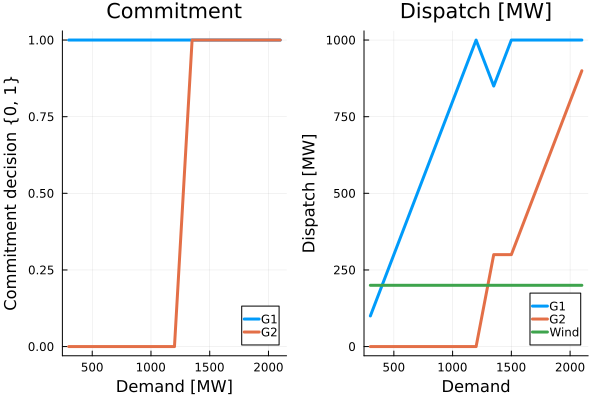

In [18]:
commitment_plot = StatsPlots.@df(
    uc_df,
    Plots.plot(
        :demand,
        [:commitment_G1, :commitment_G2],
        labels = ["G1" "G2"],
        title = "Commitment",
        legend = :bottomright,
        linewidth = 3,
        xlabel = "Demand [MW]",
        ylabel = "Commitment decision {0, 1}",
    ),
)

dispatch_plot = StatsPlots.@df(
    uc_df,
    Plots.plot(
        :demand,
        [:dispatch_G1, :dispatch_G2, :dispatch_wind],
        labels = ["G1" "G2" "Wind"],
        title = "Dispatch [MW]",
        legend = :bottomright,
        linewidth = 3,
        xlabel = "Demand",
        ylabel = "Dispatch [MW]",
    ),
)

Plots.plot(commitment_plot, dispatch_plot)